# OCG 577 HW 7-2
## Abby Baskind
## 21 October 2023

In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
import H_poly2 as hpoly2
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

In [2]:
import carbon as carbon
import numpy.ma as ma

# Changes to `carbon.py`
1. Since the input data is masked, I had to remove the requirement of no nan values. Easy enough to do.
2. Previously, my functions were only able to handle 1D data. Obviously, the global data is (at least) 2D, so I had to address that. \
    a. First, I needed to reshape the arrays where I store the results. For example: `pH = np.zeros(TA.shape)` \
    b. Second, I had to loop through the data differently as the dimensions increased from 1 to 2. I added an `if` statement (or several) to check the dimensions of the input. If the input has 2 dimensions, I had to implement nested `for` loops that loop through the i and j dimensions. \
    c. At this time, I am currently too lazy to amend the code to be able to handle more than 2 dimensions. Now that I have figured out 2 dimensions, I can easily add functionality for higher dimensions. Relavant higher dimensions might be 3D or 4D. I got around this for now by simply raising an error when `data.ndim > 2`.
3. The root finding functions will not work (at least as intended) at masked points or nan points. This causes the code to get stuck in an infinite loop. I added `if` statements to check if data at (i,j) is masked or nan. If masked or nan, I redefined `Hhi` and `Hlo` as nan values, which terminates the loop and yields nan results. 

## Read data

In [3]:
lat = np.loadtxt('/Users/akbaskind/Documents/Python Scripts/OCG577/data/latitude.txt')
lon = np.loadtxt('/Users/akbaskind/Documents/Python Scripts/OCG577/data/longitude.txt')
DIC = np.loadtxt('/Users/akbaskind/Documents/Python Scripts/OCG577/data/SurfDIC.txt')
TA = np.loadtxt('/Users/akbaskind/Documents/Python Scripts/OCG577/data/SurfAlk.txt')
T = np.loadtxt('/Users/akbaskind/Documents/Python Scripts/OCG577/data/SurfT.txt')
S = np.loadtxt('/Users/akbaskind/Documents/Python Scripts/OCG577/data/SurfS.txt')

## Mask arrays

In [4]:
dic = ma.masked_invalid(DIC)
ta = ma.masked_invalid(TA)
s = ma.masked_invalid(S)
t = ma.masked_invalid(T)

In [7]:
s.mean()

33.91845466424438

## Plot original data

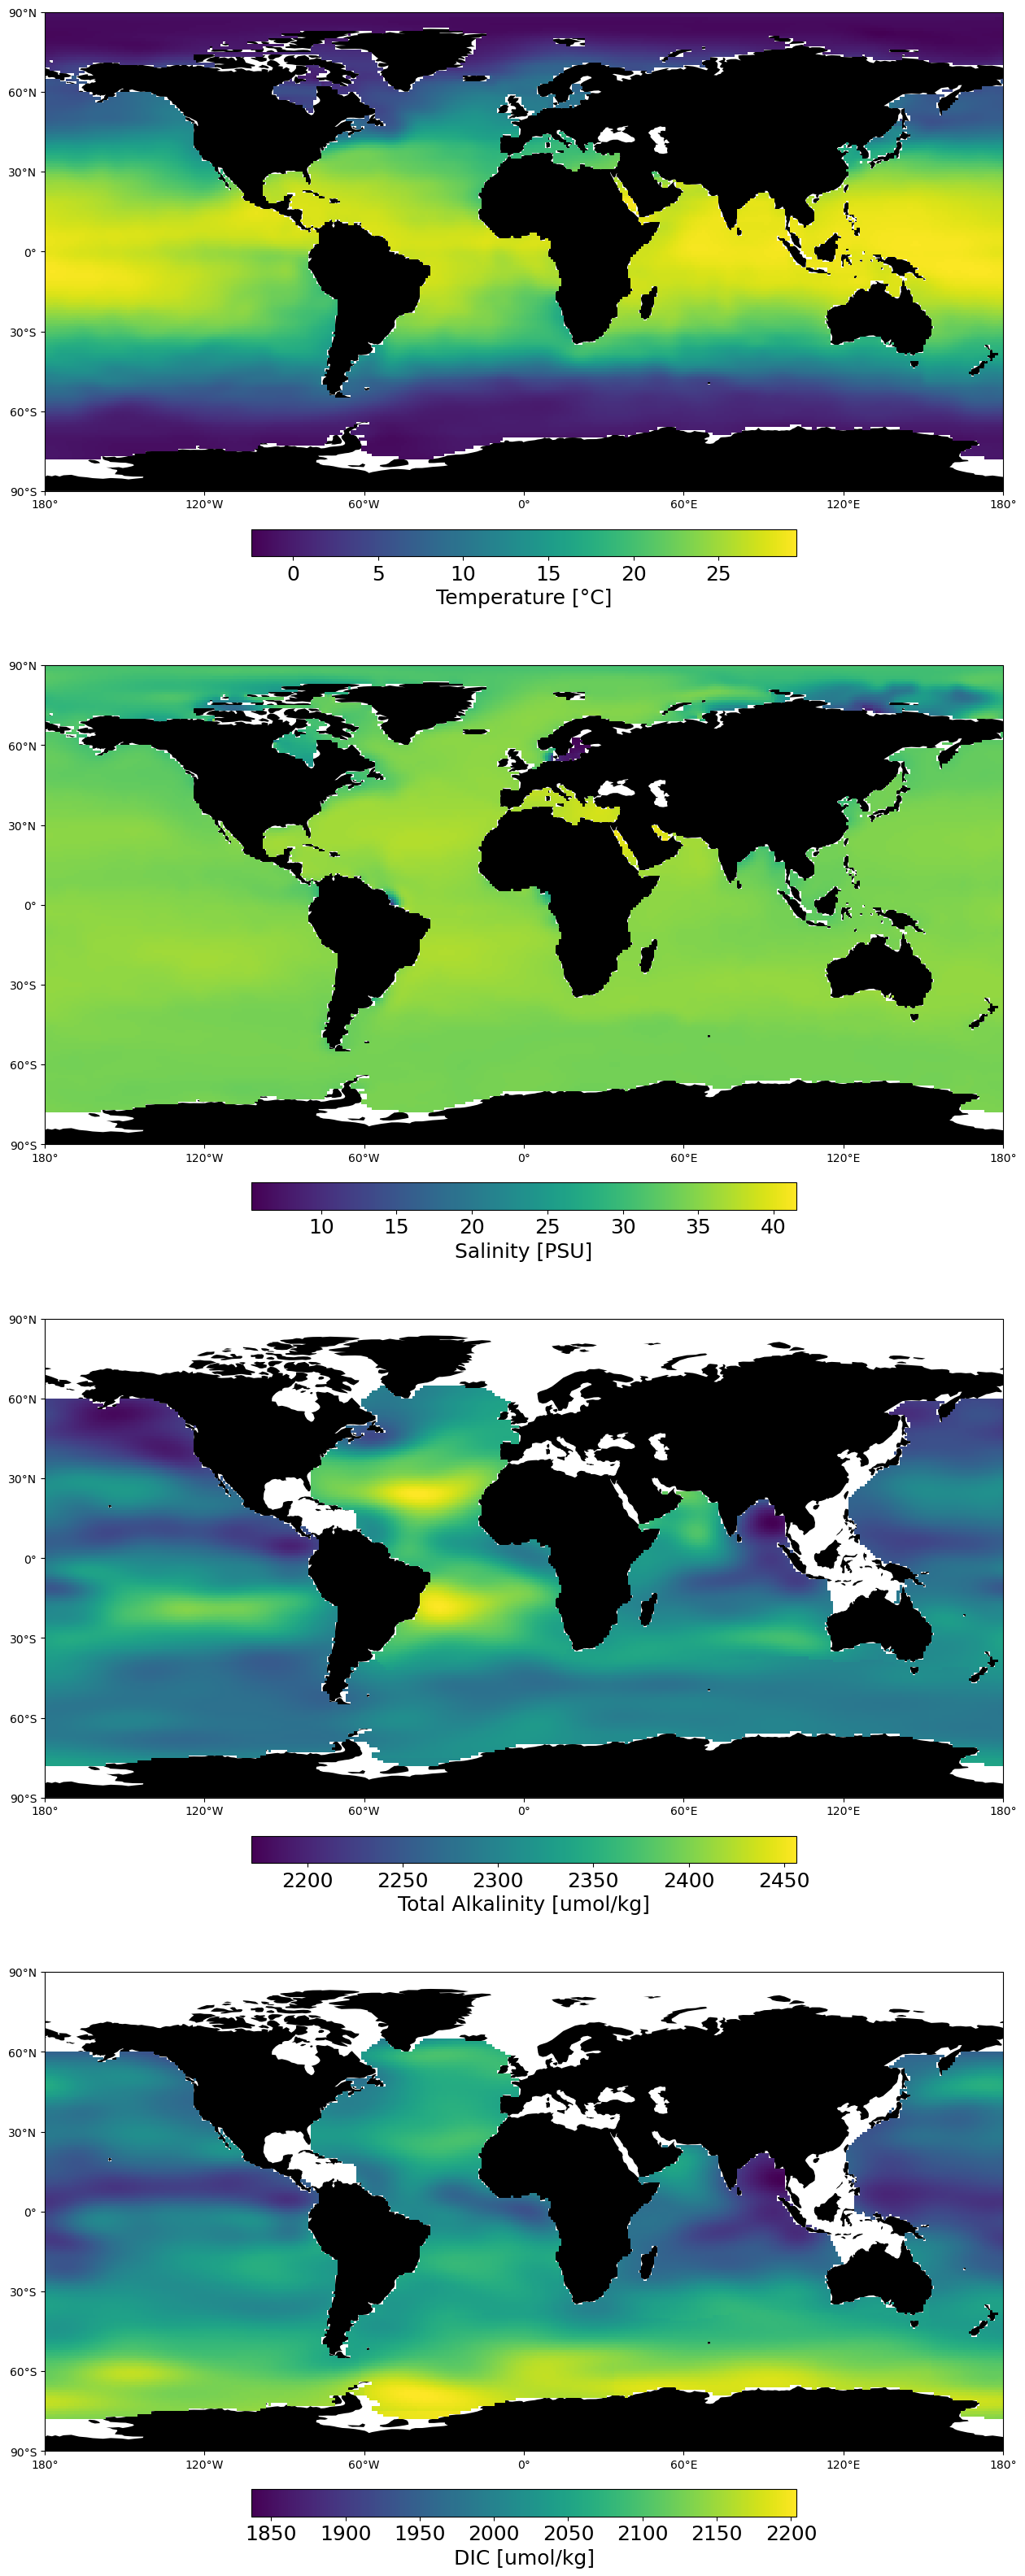

In [20]:
fig, axarr = plt.subplots(nrows = 4, figsize = [20,40],subplot_kw={'projection':ccrs.PlateCarree()})
import cartopy as cart
axarr = axarr.flatten()
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

# Temperature
ax = axarr[0]
C = t
im = ax.pcolormesh(lon, lat, C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Temperature [°C]')
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.add_feature(cart.feature.LAND, facecolor='black')

# Salinity
ax = axarr[1]
C = s
im = ax.pcolormesh(lon, lat, C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Salinity [PSU]')
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.add_feature(cart.feature.LAND, facecolor='black')

# TA
ax = axarr[2]
C = ta
im = ax.pcolormesh(lon, lat, C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Total Alkalinity [umol/kg]')
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.add_feature(cart.feature.LAND, facecolor='black')

# DIC
ax = axarr[3]
C = dic
im = ax.pcolormesh(lon, lat, C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('DIC [umol/kg]')
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.add_feature(cart.feature.LAND, facecolor='black')

## Create pCO2 array
that is the same size as the input data and is filled with 350 µatm.

In [5]:
pCO2 = np.zeros(ta.shape)
pCO2[:,:] = 350
pCO2

array([[350., 350., 350., ..., 350., 350., 350.],
       [350., 350., 350., ..., 350., 350., 350.],
       [350., 350., 350., ..., 350., 350., 350.],
       ...,
       [350., 350., 350., ..., 350., 350., 350.],
       [350., 350., 350., ..., 350., 350., 350.],
       [350., 350., 350., ..., 350., 350., 350.]])

## Solve using pCO2
Python is not happy with me redefining masked data as nan, but I am ok with it for now at least.

In [6]:
results = carbon.solver(TA = ta, pCO2 = pCO2, temperature = t, salinity = s)

/Users/akbaskind/Documents/Python Scripts/OCG577/carbon.py:803: UserWarning: Warning: converting a masked element to nan.
  if not ma.is_masked(sol) or not math.isnan(sol):
/Users/akbaskind/Documents/Python Scripts/OCG577/carbon.py:821: UserWarning: Warning: converting a masked element to nan.
  HCO3[i,j] = (k1[i,j] * co2star[i,j])/H[i,j]
/Users/akbaskind/Documents/Python Scripts/OCG577/carbon.py:823: UserWarning: Warning: converting a masked element to nan.
  CO3[i,j] = (k2[i,j] * HCO3[i,j])/H[i,j]
/Users/akbaskind/Documents/Python Scripts/OCG577/carbon.py:825: UserWarning: Warning: converting a masked element to nan.
  Csat[i,j] = CO3[i,j] + co2star[i,j] + HCO3[i,j]


NameError: name 'DIC' is not defined

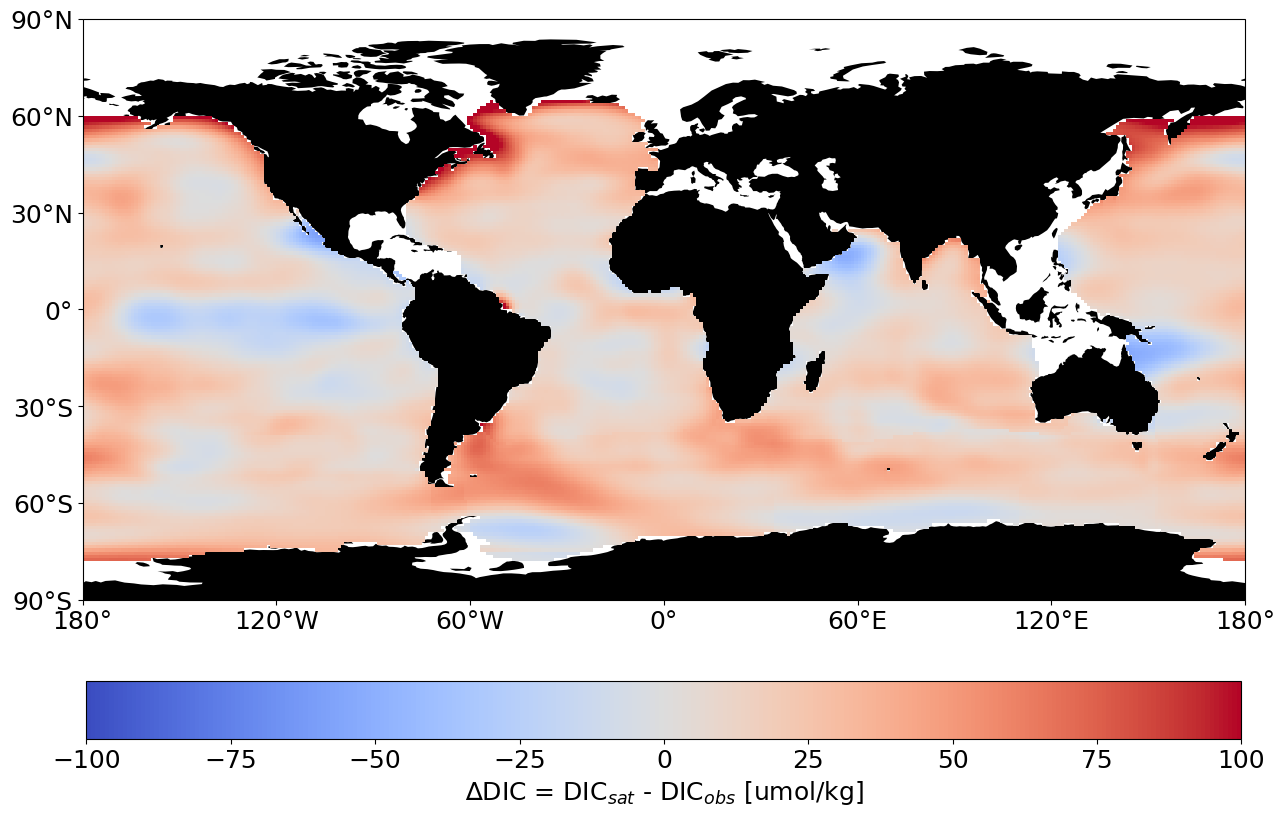

In [23]:
fig, ax = plt.subplots(figsize = [15,15],subplot_kw={'projection':ccrs.PlateCarree()})
import cartopy as cart

C = results['DIC'] - dic
x,y = np.meshgrid(lon, lat)
im = ax.pcolormesh(lon, lat, C, cmap = 'coolwarm', vmin  = -100, vmax = 100)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('∆DIC = DIC$_{sat}$ - DIC$_{obs}$ [umol/kg]')
# ax.set_title('[H+] from GFDL-ESM4', fontsize = 24)
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
# ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='black')

# Dicussion
Rather than plot the difference between equilibrium DIC and observed DIC as a scatter plot, I chose to keep the data in map form, since I had a feeling there would be a spatial pattern to DIC disequilibria. I defined the DIC disequilibrium as saturation minus observed, such that when the water is undersaturated in DIC (meaning saturation DIC is higher than observed) the data is red and when the water is oversaturated with DIC (meaning observed DIC is higher than saturation) the data is blue.

First, let's explore our primary assumption in solving for DIC using observed TA and pCO2 = 350 uatm. The surface ocean is not universally 350 uatm. For one, atmosphere levels are now closer to 410 uatm. And further, the surface ocean is rarely in equilibrium with the atmosphere. This is to say, we are solving for DIC with non-realisitic inputs. 

While it is easy to believe DIC can be undersaturated, as biological production in the surface consumes DIC generally faster than respiration because of adequate light, the regions of oversaturation of DIC are more interesting. We see these regions generally near upwelling regimes, where an excess of remineralized carbon that is highly soluble in the cold deep water reaches the surface. This would, of course, indicate CO2 outgassing in the real world. Alternatively, as I would argue is likely the case in open ocean "deserts," respiration could actually be outpacing production where nutrients are limiting or perhaps even light is limiting, thus representing a net source for carbon. This is to say, the increased respiration creates an excess of DIC in the water column. But you know, maybe I am just talking out of my ass here, but the thesis statement of all this bs is that disequilibria is a given when we factor in pCO2 disequilibria/air-sea flux and the biological pump.